In [ ]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.utils.colab.set_colab_file_id('1wK42g53rS83BG6I73JaBtnBS8RwaM6TZ')

In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import EMNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [ ]:
# Project name used for jovian.commit
project_name = 'Emnist'

In [ ]:
dataset = EMNIST(root='data/', download=True, transform=ToTensor(), split= 'byclass')
test_dataset = EMNIST(root='data/', train=False, transform=ToTensor(),split= 'byclass')

Extracting data/EMNIST/raw/emnist.zip to data/EMNIST/raw
Processing byclass


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Processing bymerge
Processing balanced
Processing letters
Processing digits
Processing mnist
Done!


In [ ]:
dataset_size = len(dataset)
dataset_size

697932

In [ ]:
test_dataset_size = len(test_dataset)
test_dataset_size

116323

In [ ]:
classes = dataset.classes
classes

['t',
 'b',
 'F',
 'T',
 'B',
 'V',
 '2',
 'i',
 'm',
 'W',
 'P',
 'E',
 'H',
 'C',
 'n',
 '0',
 'q',
 'x',
 'a',
 'N',
 'O',
 'Q',
 'k',
 'z',
 'J',
 'g',
 'r',
 'A',
 '5',
 'u',
 'e',
 '3',
 'y',
 'D',
 'I',
 'G',
 'c',
 'l',
 'f',
 'h',
 '1',
 'S',
 '9',
 '7',
 'U',
 'Y',
 'v',
 'Z',
 'd',
 'w',
 'R',
 's',
 'M',
 'X',
 '4',
 'p',
 '8',
 'j',
 'o',
 'L',
 'K',
 '6']

In [ ]:
num_classes = len(classes)
num_classes

62

In [ ]:
img, label = dataset[0]
img_shape = img.shape
img_shape

torch.Size([1, 28, 28])

Label: 18


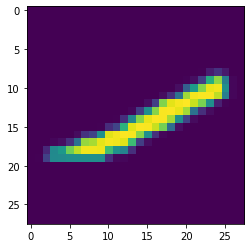

In [ ]:
image, label = test_dataset[0]
plt.imshow(image[0])
print('Label:', label)

# **Preparing Data for Training**

In [ ]:
torch.manual_seed(55)
val_size = 10000
train_size = len(dataset) - val_size

In [ ]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(687932, 10000)

In [ ]:
batch_size=128

In [ ]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

images.shape: torch.Size([128, 1, 28, 28])


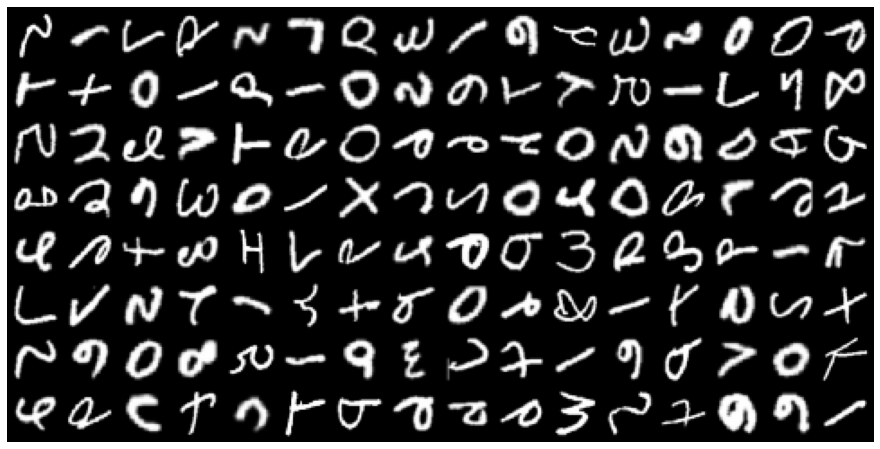

In [ ]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

# **Base Modal Class and Training on GPU**

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
torch.cuda.is_available()

False

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()
device

device(type='cpu')

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

# **Training the model**

In [ ]:
input_size = 1*28*28
output_size = 62

In [ ]:
class Model(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # hidden1 layer
        self.linear1 = nn.Linear(input_size, 1000)
        # hidden2 layer
        self.linear2 = nn.Linear(1000, 500)
        # output layer
        self.linear3 = nn.Linear(500, 62)
    
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        # Apply layers & activation functions
        out = self.linear1(out)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        return out

In [ ]:
model = to_device(Model(), device)

In [ ]:
history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.0166015625, 'val_loss': 4.120631694793701}]

Training the model to improve accuracy

In [ ]:
history += fit(10, 1e-5, model, train_loader, val_loader)

Epoch [0], val_loss: 4.1143, val_acc: 0.0242
Epoch [1], val_loss: 4.1080, val_acc: 0.0364
Epoch [2], val_loss: 4.1016, val_acc: 0.0490
Epoch [3], val_loss: 4.0952, val_acc: 0.0594
Epoch [4], val_loss: 4.0886, val_acc: 0.0648
Epoch [5], val_loss: 4.0819, val_acc: 0.0696
Epoch [6], val_loss: 4.0750, val_acc: 0.0712
Epoch [7], val_loss: 4.0680, val_acc: 0.0725
Epoch [8], val_loss: 4.0606, val_acc: 0.0729
Epoch [9], val_loss: 4.0531, val_acc: 0.0736


In [ ]:
history += fit(10, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 3.1647, val_acc: 0.3635
Epoch [1], val_loss: 2.3092, val_acc: 0.4744
Epoch [2], val_loss: 1.8540, val_acc: 0.5434
Epoch [3], val_loss: 1.6080, val_acc: 0.5922
Epoch [4], val_loss: 1.4665, val_acc: 0.6152
Epoch [5], val_loss: 1.3712, val_acc: 0.6342
Epoch [6], val_loss: 1.3011, val_acc: 0.6461
Epoch [7], val_loss: 1.2467, val_acc: 0.6561
Epoch [8], val_loss: 1.2026, val_acc: 0.6655
Epoch [9], val_loss: 1.1658, val_acc: 0.6722


In [ ]:
history += fit(10, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.9455, val_acc: 0.7266
Epoch [1], val_loss: 0.8115, val_acc: 0.7616
Epoch [2], val_loss: 0.7272, val_acc: 0.7835
Epoch [3], val_loss: 0.6713, val_acc: 0.7951
Epoch [4], val_loss: 0.6319, val_acc: 0.8062
Epoch [5], val_loss: 0.6018, val_acc: 0.8104
Epoch [6], val_loss: 0.5726, val_acc: 0.8182
Epoch [7], val_loss: 0.5561, val_acc: 0.8256
Epoch [8], val_loss: 0.5418, val_acc: 0.8287
Epoch [9], val_loss: 0.5248, val_acc: 0.8329


In [ ]:
history += fit(10, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.5180, val_acc: 0.8323
Epoch [1], val_loss: 0.5167, val_acc: 0.8348
Epoch [2], val_loss: 0.5152, val_acc: 0.8348
Epoch [3], val_loss: 0.5142, val_acc: 0.8348
Epoch [4], val_loss: 0.5135, val_acc: 0.8360
Epoch [5], val_loss: 0.5123, val_acc: 0.8343
Epoch [6], val_loss: 0.5112, val_acc: 0.8366
Epoch [7], val_loss: 0.5099, val_acc: 0.8361
Epoch [8], val_loss: 0.5094, val_acc: 0.8360
Epoch [9], val_loss: 0.5076, val_acc: 0.8365


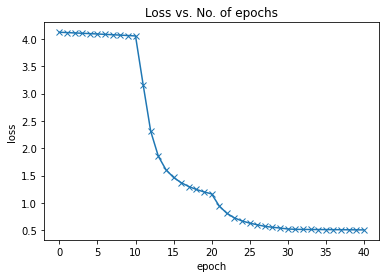

In [ ]:
plot_losses(history)

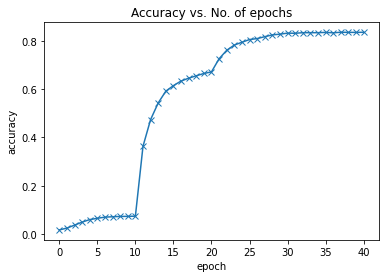

In [ ]:
plot_accuracies(history)

In [ ]:
result = evaluate(model, test_loader)
result

{'val_acc': 0.8303802609443665, 'val_loss': 0.5122147798538208}

Label: 2


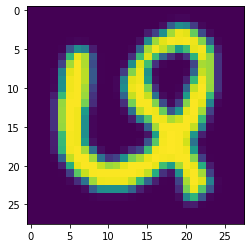

In [ ]:
image, label = train_ds[0]
plt.imshow(image[0])
print('Label:', label)

Label: 6


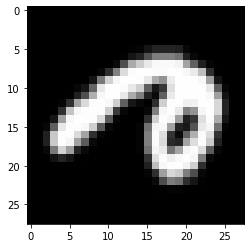

In [ ]:
image, label = train_ds[788]
plt.imshow(image[0], cmap='gray')
print('Label:', label)

Label: 2


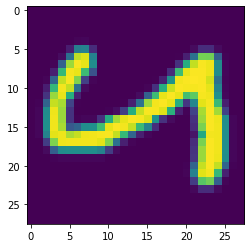

In [ ]:
image, label = train_ds[8738]
plt.imshow(image[0])
print('Label:', label)

Label: 39


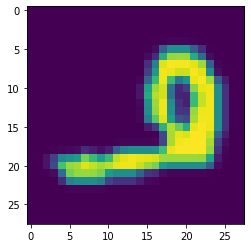

In [ ]:
image, label = train_ds[409]
plt.imshow(image[0])
print('Label:', label)

In [ ]:
torch.save(model.state_dict(), 'Emnist')

Final test accuracy and loss

In [ ]:
test_acc = result['val_acc']
test_loss = result['val_loss']
test_acc, test_loss

(0.8303802609443665, 0.5122147798538208)

In [ ]:
jovian.commit(project=project_name, outputs=['Emnist'], environment=None)

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: 